In [1]:
import os
os.chdir('/data/hyeryung/mucoco')
import yaml

import wandb
from tqdm import tqdm
import torch
import torch.nn as nn
import pandas as pd
from torch.optim import AdamW
import seaborn as sns
from sklearn.metrics import ndcg_score

import numpy as np
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support, accuracy_score


from new_module.em_training.nli.models import EncoderModel
from new_module.em_training.nli.data_handling import load_nli_data, load_nli_test_data, NLI_Dataset, NLI_DataLoader
from new_module.em_training.nli.train import *
from new_module.em_training.nli.train_modules import *


/data/hyeryung/.conda/envs/loc-edit/lib/python3.8/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [30]:

def plot_roc_curve_real_num(array_positive, array_negative, path_to_save_figure):
    """
    code adapted from Mooho's code
    """
    # Combine the positive and negative arrays
    y_true = np.array([1] * len(array_positive) + [0] * len(array_negative))
    pos = [-1 * a for a in array_positive]
    neg = [-1 * a for a in array_negative]
    # scores = np.array(array_positive + array_negative) 
    scores = np.array(pos + neg) 
    
    # Calculate FPR and TPR for various thresholds
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    auroc = roc_auc_score(y_true, scores)
    
    # Plotting the ROC curve
    fig = plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve with AUROC={auroc:.4f}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    # Save the plot to the specified path
    # plt.savefig(path_to_save_figure)
    # plt.close()
    return auroc

def plot_observed_predicted_boxplot(array_energy, array_labels, path_to_save_figure):
    predicted_result = pd.DataFrame({'labels': array_labels, 'predicted_proba': array_energy})
    predicted_result['labels_c'] = pd.cut(predicted_result['labels'], np.arange(-0.1, 1.01, 0.1))
    g = sns.boxplot(predicted_result, x='labels_c', y='predicted_proba')
    plt.xticks(rotation=30)
    plt.xticks(rotation=30)
    plt.title("Predicted Values by Bins of Observed Values")
    plt.xlabel("Bins in Labels")
    plt.ylabel("Energy")
    # plt.savefig(path_to_save_figure)
    # plt.close()

In [13]:
true = [0,0,0,0,0,0,0,0,0,0,0,0,0.15,0.35,0.65,0.75,1,1,1,1] # 54321
pred_1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0.3,1,1,1,1,1] # Multi CE 
pred_2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0.05,0.8,1,1,1,1] # Multi CE + Margin Ranking
pred_3 = [0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.4,0.6,0.8,0.15,0.3,0.5, 0.8, 0.8, 0.8, 0.8, 0.8] # 54321

print(f"case 1. pearson R {pearsonr(true, pred_1).statistic:.4f}, ndcg {ndcg_score([true], [pred_1]):.4f}")
print(f"case 2. pearson R {pearsonr(true, pred_2).statistic:.4f}, ndcg {ndcg_score([true], [pred_2]):.4f}")
print(f"case 3. pearson R {pearsonr(true, pred_3).statistic:.4f}, ndcg {ndcg_score([true], [pred_3]):.4f}")

case 1. pearson R 0.9640, ndcg 0.9819
case 2. pearson R 0.9410, ndcg 0.9954
case 3. pearson R 0.7887, ndcg 0.9128


In [62]:
api = wandb.Api()
run_id = 'hayleyson/nli_energynet/ksavttkv' # # 
run = api.run(run_id)
config = run.config

model_path = config['model_path']
print(f"model_path: {model_path}")

model_path: models/nli/roberta_large_snli_mnli_anli_train_dev_with_finegrained_finegrained_labels_mse+margin_ranking/1726396775/best_model.pth


In [63]:
# model_path = config['model_path'].split('.pth')[0] + '_add_ranking_loss.pth'
# model_path =  config['model_path'].split('.pth')[0] + '_loss.pth'
# model_path =  config['model_path'].split('.pth')[0] + '_pearsonr.pth'

In [64]:
# config = load_config('new_module/em_training/config.yaml')
config['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EncoderModel(config)
model = model.to(config['device'])
model.load_state_dict(torch.load(model_path))

# config['model_path'] = model_path

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [65]:
# ## hf model
# config = load_config('new_module/em_training/config.yaml')
# model = AutoModelForSequenceClassification.from_pretrained('ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli')
# model = model.to('cuda')
# tokenizer = AutoTokenizer.from_pretrained('ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli')

In [66]:
#### comment out for now! DONT FORGET TO UNCOMMENT LATER
train_dev_data = load_nli_data(output_file_path=config['energynet']['dataset_path'])
# train_add_data = load_additional_nli_training_data(output_file_path='/data/hyeryung/mucoco/data/nli/snli_mnli_anli_train_without_finegrained.jsonl')
test_data = load_nli_test_data(output_file_path='/data/hyeryung/mucoco/data/nli/snli_mnli_anli_test_with_finegrained.jsonl')

# train_dev_data = pd.concat([train_dev_data, train_add_data], ignore_index=True)
train_data = train_dev_data.loc[train_dev_data['split'] == 'train']
dev_data = train_dev_data.loc[train_dev_data['split'] == 'dev']

## IMPT. 'finegrained_labels' == degree of contradiction (real number between 0 and 1) == portion of annotators who labeled the sample as "contradiction"
# train_dataset = NLI_Dataset(train_data, label_column=config['energynet']['label_column'])
dev_dataset = NLI_Dataset(dev_data, label_column=config['energynet']['label_column'])
test_dataset = NLI_Dataset(test_data, label_column=config['energynet']['label_column'])

# train_dataloader = NLI_DataLoader(dataset=train_dataset, 
#                                     config = config, 
#                                     mode='train', 
#                                     tokenizer=model.tokenizer).get_dataloader()
dev_dataloader = NLI_DataLoader(dataset=dev_dataset, 
                                    config = config, 
                                    mode='dev', 
                                    tokenizer=model.tokenizer).get_dataloader()
test_dataloader = NLI_DataLoader(dataset=test_dataset,
                                 config=config,
                                 mode='test',
                                 tokenizer=model.tokenizer).get_dataloader()

Preprocessed dataset already exists. Loading data from file
Preprocessed dataset already exists. Loading data from file


In [67]:
# ## for hf model
# test_data = load_nli_test_data(output_file_path='/data/hyeryung/mucoco/data/nli/snli_mnli_anli_test_with_finegrained.jsonl')
# test_dataset = NLI_Dataset(test_data, label_column=config['energynet']['label_column'])

# from torch.utils.data import Dataset, DataLoader
# class NLI_DataLoader:
    
#     def __init__(self, dataset, config, mode, tokenizer):
#         self.tokenizer = tokenizer
#         self.dataset = dataset
#         self.config = config
#         self.batch_size = self.config['energynet']['batch_size']
#         self.mode = mode
    
#     def collate_fn(self, batch):
#         premises = [x[0] for x in batch]
#         hypotheses = [x[1] for x in batch]
#         labels = [x[2] for x in batch]
#         finegrained_labels = [x[3] for x in batch]
        
#         sequences = [(p, h) for p, h in zip(premises, hypotheses)]
#         tokenized_sequences = self.tokenizer(sequences, padding=True, truncation=True, return_tensors='pt')
#         if self.config['energynet']['loss'] == 'cross_entropy':
#             labels = torch.Tensor(labels).reshape(-1, 1)
#             labels = torch.tile(labels, (1,2))
#             labels[:, 0] = 1 - labels[:, 0] 
#         elif self.config['energynet']['loss'] == 'binary_cross_entropy':
#             labels = torch.LongTensor(labels)
#         elif self.config['energynet']['loss'] == 'mse':
#             labels = torch.Tensor(labels).reshape(-1, 1)
#         else:
#             raise NotImplementedError('Label column not recognized')
        
#         return {'input_ids': tokenized_sequences['input_ids'].to(self.config['device']), 
#                 'attention_mask': tokenized_sequences['attention_mask'].to(self.config['device']), 
#                 'labels': labels.to(self.config['device']),
#                 'finegrained_labels': finegrained_labels}
    
#     def get_dataloader(self):
#         return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True if self.mode=='train' else False, collate_fn=self.collate_fn)
    
# test_dataloader = NLI_DataLoader(dataset=test_dataset,
#                                  config=config,
#                                  mode='test',
#                                  tokenizer=tokenizer).get_dataloader()
        

In [68]:
# print(f"num batches in train data: {len(train_dataloader)}")
print(f"num batches in dev data: {len(dev_dataloader)}")
print(f"num batches in test data: {len(test_dataloader)}")

num batches in dev data: 351
num batches in test data: 814


In [69]:
# if (config['energynet']['loss'] == 'cross_entropy') or (config['energynet']['loss'] == 'binary_cross_entropy'):
#     criterion = nn.CrossEntropyLoss()
# elif config['energynet']['loss'] == 'mse':
#     criterion = nn.MSELoss()
# else:
#     raise NotImplementedError('Not a valid loss name')

In [70]:
config

{'device': device(type='cuda'),
 'locate': {'type': 'gradnorm'},
 'energynet': {'loss': 'mse+margin_ranking',
  'margin': 1,
  'max_lr': '1e-5',
  'base_model': 'roberta-large',
  'batch_size': 16,
  'energy_col': 1,
  'eval_every': 100,
  'num_epochs': 3,
  'output_form': 'real_num',
  'dataset_path': 'data/nli/snli_mnli_anli_train_dev_with_finegrained.jsonl',
  'label_column': 'finegrained_labels',
  'weight_decay': 0.03,
  'ckpt_save_path': 'models/nli/roberta_large_snli_mnli_anli_train_dev_with_finegrained_finegrained_labels_mse+margin_ranking/1726396775',
  'add_ranking_loss': True},
 'model_path': 'models/nli/roberta_large_snli_mnli_anli_train_dev_with_finegrained_finegrained_labels_mse+margin_ranking/1726396775/best_model.pth'}

In [71]:
config['energynet']['label_column']

'finegrained_labels'

In [72]:
config['energynet']['loss']

'mse+margin_ranking'

In [73]:
epoch=0
overall_step=0
model.eval()
with torch.no_grad():
    dev_loss = 0
    dev_e = []
    dev_labels = []
    for dev_batch in dev_dataloader:
        
        if config['locate']['type'] == 'gradnorm':
            dev_outputs, _ = model(input_ids = dev_batch['input_ids'],
                        attention_mask = dev_batch['attention_mask'])
        else:
            dev_outputs = model(input_ids = dev_batch['input_ids'],
                        attention_mask = dev_batch['attention_mask'])
        if config['energynet']['loss'] == 'mse': 
            dev_predictions = torch.sigmoid(dev_outputs)
        else:
            dev_predictions = dev_outputs
        
        # dev_loss += criterion(dev_predictions, dev_batch['labels'])
        
        if (config['energynet']['loss'] == 'cross_entropy') or (config['energynet']['loss'] == 'binary_cross_entropy'):
            dev_predictions = torch.softmax(dev_outputs, dim=-1)
            
        dev_e.extend(dev_predictions.cpu().squeeze(-1).tolist())
        try:
            dev_labels.extend(dev_batch['labels'].cpu().squeeze(-1).tolist())
        except:
            dev_labels.extend(dev_batch['labels'].cpu().tolist())
        
    # dev_loss /= len(dev_dataloader)
    


In [74]:
# ## hf model
# config['locate']['type'] = 'attention'
# epoch=0
# overall_step=0
# model.eval()
# with torch.no_grad():
#     dev_loss = 0
#     dev_e = []
#     dev_labels = []
#     for dev_batch in test_dataloader:
        
#         if config['locate']['type'] == 'gradnorm':
#             dev_outputs, _ = model(input_ids = dev_batch['input_ids'],
#                         attention_mask = dev_batch['attention_mask'])
#         else:
#             dev_outputs = model(input_ids = dev_batch['input_ids'],
#                         attention_mask = dev_batch['attention_mask'])
#         if config['energynet']['loss'] == 'mse': 
#             dev_predictions = torch.sigmoid(dev_outputs)
#         else:
#             dev_predictions = dev_outputs
        
#         # dev_loss += criterion(dev_predictions, dev_batch['labels'])
        
#         if (config['energynet']['loss'] == 'cross_entropy') or (config['energynet']['loss'] == 'binary_cross_entropy'):
#             dev_outputs = dev_outputs.logits
#             dev_predictions = torch.softmax(dev_outputs, dim=-1)
            
#         dev_e.extend(dev_predictions.cpu().squeeze(-1).tolist())
#         try:
#             dev_labels.extend(dev_batch['labels'].cpu().squeeze(-1).tolist())
#         except:
#             dev_labels.extend(dev_batch['labels'].cpu().tolist())
        
#     # dev_loss /= len(dev_dataloader)
    


In [75]:
# dev_e = torch.sigmoid(torch.Tensor(dev_e)).tolist()

In [76]:
# dev_e = (-torch.log(torch.Tensor(dev_e))).tolist()

In [77]:
try:
    contradict_proba = torch.Tensor(dev_e)[:, config['energynet']['energy_col']]
except:
    contradict_proba = torch.Tensor(dev_e)

try:
    if config['energynet']['output_form'] == '3dim_vec':
        contradict_labels = torch.Tensor(dev_data['binary_labels'].tolist())
    elif config['energynet']['output_form'] == '2dim_vec':
        contradict_labels = torch.Tensor(dev_labels)[:, config['energynet']['energy_col']]
    else:
        contradict_labels = torch.Tensor(dev_labels)
except: 
    print("Error")
    
print(f"contradict_proba: {contradict_proba[:10]}")
print(f"contradict_labels: {contradict_labels[:10]}")

contradict_proba: tensor([-2.7960, -3.6370, -2.7548, -4.3823,  2.9954, -1.4998, -3.4878,  0.9810,
         2.8656,  2.3646])
contradict_labels: tensor([0.0000, 0.2000, 0.0000, 0.0000, 1.0000, 0.2000, 0.0000, 0.8000, 1.0000,
        0.8000])


In [78]:
# ## hf
# try:
#     contradict_proba = torch.Tensor(dev_e)[:, 2]
# except:
#     contradict_proba = torch.Tensor(dev_e)

# try:
#     contradict_labels = torch.Tensor(dev_labels)[:, 1]
# except: 
#     contradict_labels = torch.Tensor(dev_labels)
    
# print(f"contradict_proba: {contradict_proba[:10]}")
# print(f"contradict_labels: {contradict_labels[:10]}")

In [79]:
# from sklearn.metrics import confusion_matrix, precision_recall_fscore_support 
# from sklearn.metrics import ConfusionMatrixDisplay


# th = 0.5
# contradict_proba_c = torch.where(contradict_proba > th, 1, 0)
# try:
#     ConfusionMatrixDisplay.from_predictions(contradict_labels, contradict_proba_c)
#     precision, recall, fbeta_score, support = precision_recall_fscore_support(contradict_labels, contradict_proba_c, average='binary')
# except:
#     contradict_labels_c = torch.where(contradict_labels > th, 1, 0)
#     ConfusionMatrixDisplay.from_predictions(contradict_labels_c, contradict_proba_c)
#     precision, recall, fbeta_score, support = precision_recall_fscore_support(contradict_labels_c, contradict_proba_c, average='binary')


# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {fbeta_score:.2f}")

In [80]:
contradict_labels = dev_data['finegrained_labels'].values

print(torch.mean((contradict_proba-contradict_labels)**2))

from scipy.stats import pearsonr 
print(pearsonr(contradict_proba, contradict_labels))

tensor(6.6379, dtype=torch.float64)
PearsonRResult(statistic=0.712620830368359, pvalue=0.0)


In [81]:
# arr_inconsistent = [p for i, p in enumerate(contradict_proba) if contradict_labels[i] == 1]
# arr_consistent = [p for i, p in enumerate(contradict_proba) if contradict_labels[i] == 0]
arr_inconsistent = [p for i, p in enumerate(contradict_proba) if contradict_labels[i] > 0.5]
arr_consistent = [p for i, p in enumerate(contradict_proba) if contradict_labels[i] <= 0.5]

In [82]:
# determine_best_split_by_f1(arr_consistent, arr_inconsistent)

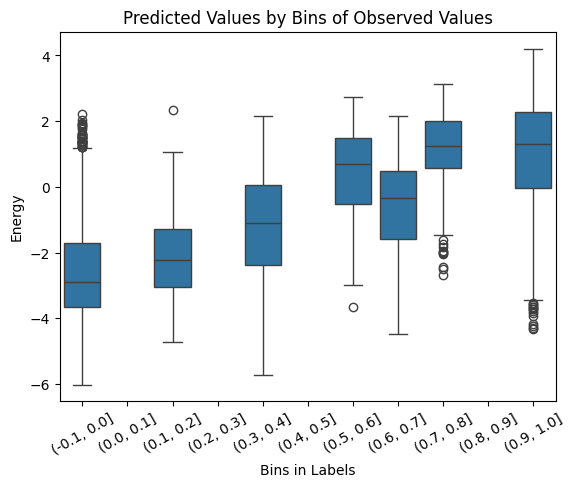

In [83]:
plot_observed_predicted_boxplot(contradict_proba, dev_data['finegrained_labels'].values, '')
# plot_observed_predicted_boxplot(contradict_proba, test_data['finegrained_labels'].values, '')

Text(0.5, 1.0, 'hist')

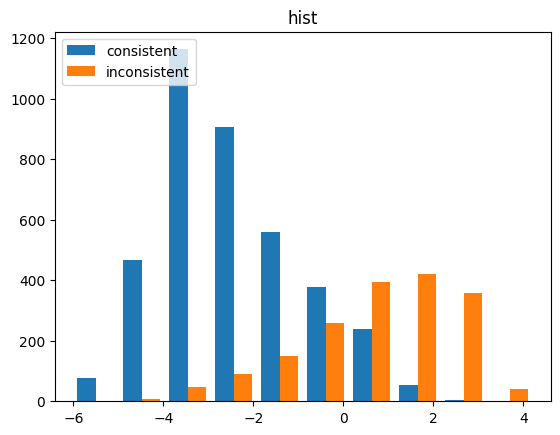

In [84]:
plt.hist([arr_consistent, arr_inconsistent], label = [ "consistent", "inconsistent"])
plt.legend(loc="upper left")
plt.title("hist")

0.9086646072075177

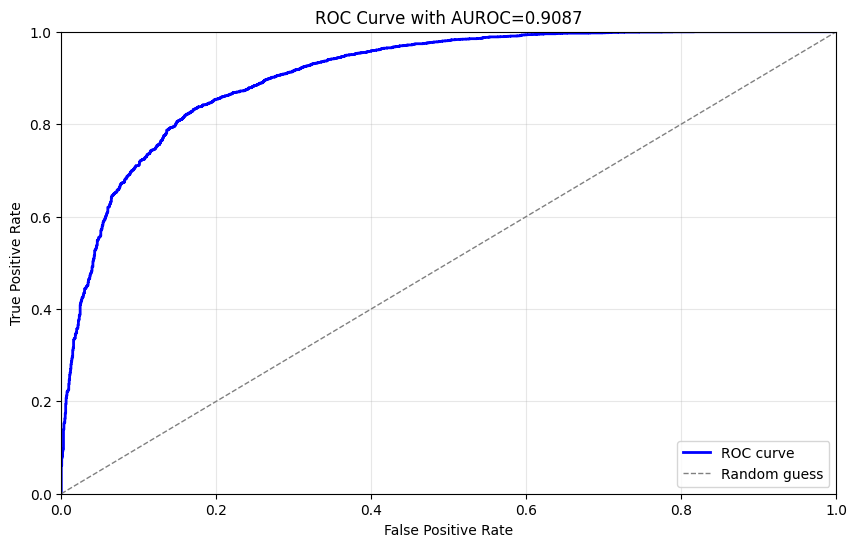

In [85]:
plot_roc_curve_real_num(arr_consistent, arr_inconsistent, "")

In [86]:


ndcg_score(contradict_labels[np.newaxis, :], contradict_proba.numpy()[np.newaxis, :])

0.9755190186740481